In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

import seaborn as sns

## Loading data from CSV to Pandas DataFrame

In [2]:
data = pd.read_csv("DataSet_PCP_Change.csv")
data.head()

,testindex,outcome,distance,visit_count,claims_daysaway,tier,fqhc,pcp_lookback,family_assignment,kid,is_ped,same_gender,same_language,same_address
0,0,0,0.071912,0,NaN,2.0,0,0,0,0,0,1,0,0
1,2,0,0.448447,0,NaN,1.0,0,0,1,1,1,0,0,0
2,5,0,0.345793,0,NaN,1.0,0,1,0,0,0,1,0,0
3,6,0,1.857032,0,NaN,1.0,0,0,1,1,1,1,0,0
4,7,1,7.222060,0,NaN,1.0,0,0,1,1,0,0,0,0


In [3]:
data.shape

(3130, 14)

In [4]:
data.groupby(by='outcome', as_index=False).agg({'testindex': pd.Series.nunique})

,outcome,testindex
0,0,3003
1,1,127


In [5]:
data[data['outcome'] == 1].head()

,testindex,outcome,distance,visit_count,claims_daysaway,tier,fqhc,pcp_lookback,family_assignment,kid,is_ped,same_gender,same_language,same_address
4,7,1,7.222060,0,NaN,1.0,0,0,1,1,0,0,0,0
21,29,1,0.376928,5,0.0,1.0,0,0,0,1,0,0,0,0
25,37,1,6.557357,9,27.0,1.0,0,1,0,0,0,1,0,0
42,69,1,0.171770,0,NaN,2.0,0,0,0,0,0,0,0,0
72,116,1,0.303698,0,NaN,3.0,0,0,0,0,0,1,0,0


## Feture Enrichement

Binning for feature `distance` is required as the boxplot clearly shows that mostly distance is in range 0 to 5. 
Raw values of feature `distance` will lead to inaccurate predictions

In [6]:
# Remove rows with missing target, separate target from predictors
data.dropna(axis=0, subset=['outcome'], inplace=True)
y = data.outcome
data.drop(['outcome'], axis=1, inplace=True)

In [7]:
# replace all NaN with 0 from the claims_daysaway column dataset
data = data.fillna(0)

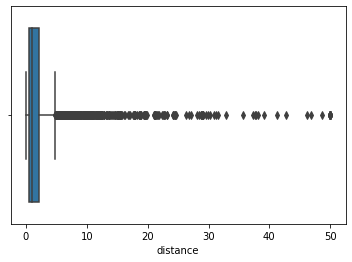

In [8]:
ax = sns.boxplot(x=data.distance)

In [9]:
# zone_labels = ["zone1", "zone2", "zone3", "zone4"]
zone_labels = ["1", "2", "3", "4"]
data['distance_bin'] = pd.cut(data['distance'], bins=[-1, 2, 5, 10, 60], labels=zone_labels)

# categories = np.array(zone_labels)
# data['distance_bin'] = pd.Categorical(data['distance_bin'], categories=categories, ordered=True)

data.drop(['distance'], axis=1, inplace=True)

### Histogram to visualize all the possible features and the spread of their values.

array([[<AxesSubplot:title={'center':'testindex'}>,
        <AxesSubplot:title={'center':'visit_count'}>,
        <AxesSubplot:title={'center':'claims_daysaway'}>],
       [<AxesSubplot:title={'center':'tier'}>,
        <AxesSubplot:title={'center':'fqhc'}>,
        <AxesSubplot:title={'center':'pcp_lookback'}>],
       [<AxesSubplot:title={'center':'family_assignment'}>,
        <AxesSubplot:title={'center':'kid'}>,
        <AxesSubplot:title={'center':'is_ped'}>],
       [<AxesSubplot:title={'center':'same_gender'}>,
        <AxesSubplot:title={'center':'same_language'}>,
        <AxesSubplot:title={'center':'same_address'}>]], dtype=object)

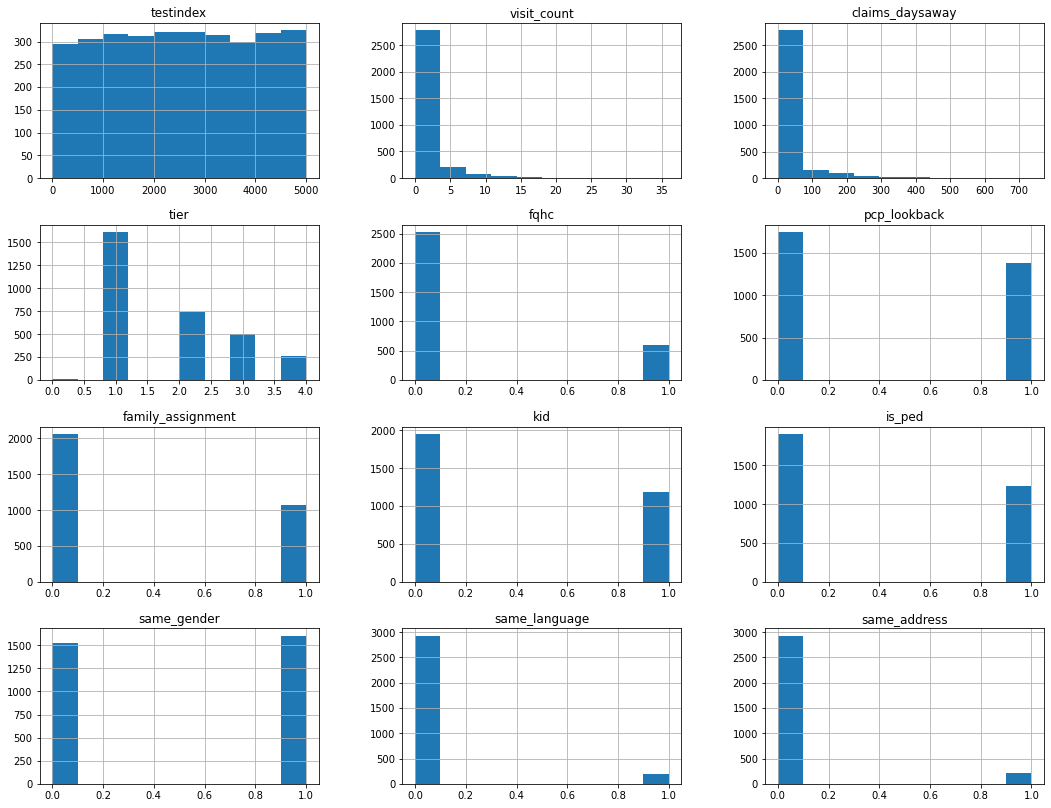

In [10]:
data.hist(figsize=(18,14))

In [11]:
print(data.shape, y.shape)

(3130, 13) (3130,)


## Split the data in Training and Testing dataset using `train_test_split` method from sklearn.

In [12]:
# Break-off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(data, y, train_size=0.8, test_size=0.2, random_state=0)

## Models and Predictions

In [13]:
model = RandomForestRegressor(n_estimators=100, random_state=0)
model.fit(X_train, y_train)
preds = model.predict(X_valid)

mean_absolute_error(y_valid, preds)

0.07523961661341853

In [14]:
model = LogisticRegression()
model.fit(X_train, y_train)
preds = model.predict(X_valid)

mean_absolute_error(y_valid, preds)

/opt/miniconda3/envs/bits-py-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/miniconda3/envs/bits-py-env/lib/python3.9/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


0.038338658146964855

In [15]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
preds = model.predict(X_valid)

mean_absolute_error(y_valid, preds)

0.07507987220447285